In [1]:
#%%
import math
import numpy as np
import inspect
import importlib

import scipy.interpolate

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import plot
pio.renderers.default = "svg"

import sys
import os
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
#sys.path.append(os.path.dirname(parent_directory))
#sys.path.append(os.path.dirname(os.path.dirname(parent_directory)))

from IoT_node_models.Energy_model                        import *
from IoT_node_models.Energy_model.Wireless_communication import *
from IoT_node_models.Hardware_Modules                    import *
from IoT_node_models.Impact_model                        import *


path_to_save_svg = "Saved_Data"



Importing IoT Node models
Importing IoT Node Energy models
Importing IoT Node Energy models
Importing Wireless communication packages
Importing Wireless communication packages
Importing custom modules data
Importing custom modules data
Importing Impact models
Importing Impact models


In [2]:
show = 0

AA_series = 3
AA_footprint = 0.165
AA_cost      = 0.25 
Batt_footprint = AA_series*AA_footprint
Batt_cost      = AA_series*AA_cost

In [3]:
placementNnodes   = 100
decomNnodes       = 100
replacementNnodes = 10

In [4]:
transport_f =   transport_footprint(km_one_way = 10, 
                                    type ="Unit", 
                                    weight_g = 500,  
                                    footprint_p_tkm = 0.545,
                                    unit_factor = 1,
                                    footprint_p_km = 0.350)

node_footprint = Node_BoM(  casing            =[0.709,    0.3932, 1.3259], #709
                            connectivtiy      =[0.517,    0.2262, 0.5817],
                            eol               =[0.0812,   0.0388, 0.1201],
                            memory            =[0,        0,      0     ],
                            others            =[0.0938,   0.0546, 0.1394],
                            pcb               =[1.17,     0.9403, 1.5696], #1.17
                            power_supply      =[0.132,    0.0446, 0.1751],
                            processing        =[0.366,    0.3665, 0.4537],
                            sensing           =[0.0539,   0.0539, 0.5561],
                            ui                =[0.0306,   0.0017, 0.1155],
                            transport         =[transport_f*show,transport_f*show,transport_f*show],
                            battery           =[Batt_footprint  ,Batt_footprint,Batt_footprint],
                            placement         =[transport_f,transport_f,transport_f],
                            replacement       =[transport_f,transport_f,transport_f],
                            decom             =[transport_f,transport_f,transport_f], 
                            placementNnodes   = placementNnodes,
                            decomNnodes       = decomNnodes,
                            replacementNnodes = replacementNnodes)
    

In [5]:
transport_c =   transport_cost( worker = 1, 
                                salary_p_hour = 20, 
                                work_hour =0.3, 
                                km_p_h = 50,km_one_way = 10, 
                                type ="Unit", 
                                weight_g = 500, cost_p_tkm =  0.2/1e3,
                                unit_factor = 1,cost_p_km = 0.2)



node_Cost   = Node_BoM(     casing            =[10    ,    0 , 0], #ABS , IP rated
                            connectivtiy      =[5.3   ,    0 , 0], #SX1276 : 5.3
                            eol               =[0     ,    0 , 0],
                            memory            =[0     ,    0 , 0],
                            others            =[1.42  ,    0 , 0], #MLCC : 0.05*15 + XTAL32MHz: 0.5 + R: 0.002*15 + D : 0.07*2  
                            pcb               =[1.17  ,    0 , 0], #PCB 60cm2 : 1.75 
                            power_supply      =[0.228 ,    0 , 0], #XC6206 : 0.228 + Diode and Transistor?
                            processing        =[3.65  ,    0 , 0], #Apollo3: 3.65
                            sensing           =[6.94  ,    0 , 0], #BME680 : 6.94
                            ui                =[0.54  ,    0 , 0], #Push button : 0.17*2 + LED SMD : 0.2*1
                            transport         =[transport_c,0 , 0],
                            battery           =[Batt_cost  ,0 , 0],
                            placement         =[transport_c,0 , 0],
                            replacement       =[transport_c,0 , 0],
                            decom             =[transport_c,0 , 0],
                            placementNnodes   = placementNnodes,
                            decomNnodes       = decomNnodes,
                            replacementNnodes = replacementNnodes)

In [6]:
def PL_model(d):
    return path_loss_PLd0(d=d, PLd0=94.40,d0=1, n=2.03)

In [7]:
node_LDO = LDO(name = "Node LDO", v_out = 3.3, i_q = 1e-3, v_in = 4.5, module_list = module_List_3V3)
node_Batt= Battery(name = "Node Battery", v = 4.5, capacity_mAh = 2800, i = 0, selfdischarge_p_year = 5)

node_lora = LoRa_Node(name= "IoT Node", 
                      module_list= module_List_3V3, PMU_composition =[node_LDO], Battery = node_Batt, 
                      MCU_module   = apollo_module_3V3, radio_module = radio_module_3V3)

node = LoRa_Node_profile("Node_profile", node_lora, MCU_active_state = apollo_state_active_3V3,
                radio_state_TX=radio_state_TX_3V3, radio_state_RX= radio_state_RX_3V3, Ptx = 2)
                
PTX_config = PTX_PABOOST_3V3
ITX_config = I_PABoost_3V3
Ptx_used = 17   

node.set_radio_parameters(SF=12 ,Coding=1,Header=True,DE = None,BW = 125e3, Payload = 50) 
node.set_TX_Power_config( P_TX= PTX_config, I_TX=ITX_config)  
node.set_TX_Power(Ptx = Ptx_used)
node.change_RX_duration(1e-3)

node.change_task_rate(node.task_rx,0)#24*60*(60/6))
node.change_task_rate(node.task_tx,24)
node.add_task(task_TPHG_3V3,24*12)

node.set_Path_loss_model(PL_model)

In [8]:
figsize = (6,3.8) #figsize = (5,4)

3.6485000000000003


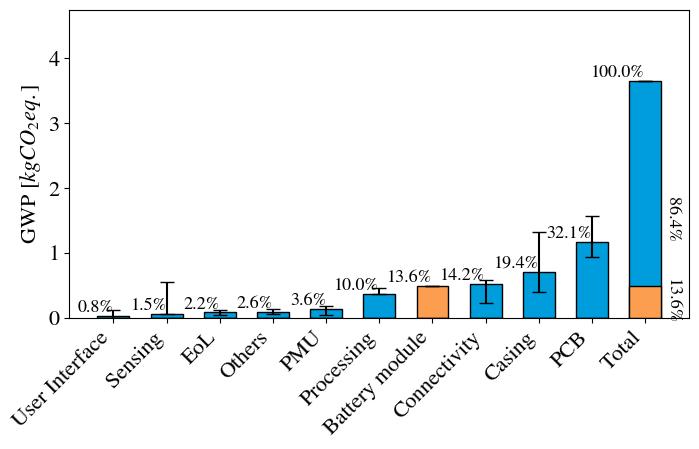

In [11]:
node_footprint.plot_footprint(filename = os.path.join(path_to_save_svg , "Node_Footprint_breakdown") ,figsize =(8,4),separatePlot=False)

-------------------------------------------------
            Tasks summary                        
-------------------------------------------------
Task name            : Sleep          TX             RX             TPHG meas.     
Times/day    [1/d]   : 1              24             0              288            
Tot. durat.  [s]     : 85708.7544     62.4468        0.0000         628.7988       
Tot. en./d   [mJ]    : 10217.1948     19269.6589     0.0000         23488.9315     
Node en./d   [mJ]    : 52975.7852      
Average pow. [mW]    : 0.6131          
-------------------------------------------------
-----------------------------------------------------------------
                        Module summary                           
-----------------------------------------------------------------
Module       State        Active [s]   Energy [mJ]  Av. Cur.[uA]  
Apollo3                   622.5607     1947.5941    6.8308        
     -       Sleep        85777.4393   770.3940     

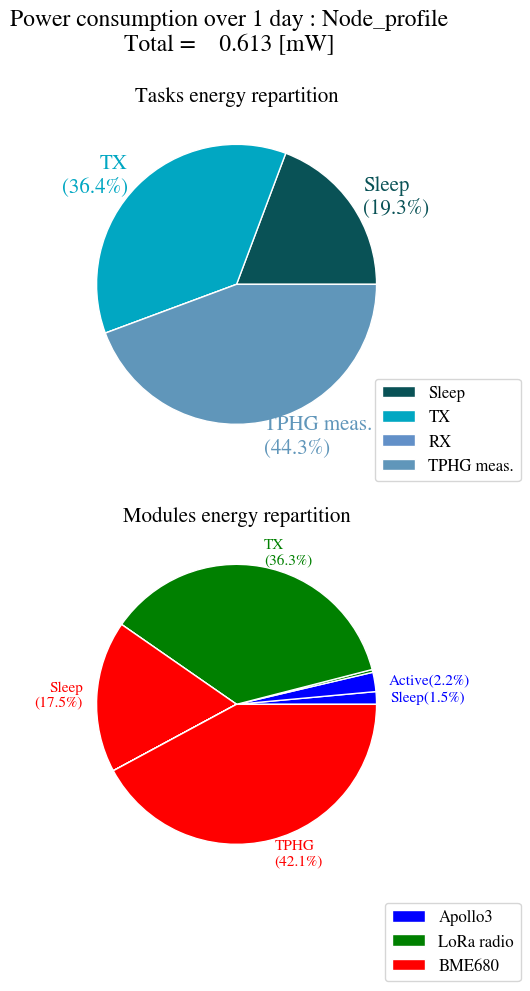

In [12]:
node.set_distance( d= 1500,recompute=True)
node.print_Tasks()
node.print_Modules()
node.plot_Power()

In [19]:
node.set_distance(d= 1500)
[res1,res2,lifetime,residue] =deployment_battery_replacement(
                                    Replacement_type = "Complete",
                                    Footprint=node_footprint,
                                    Node=node,
                                    Nyears= 20)
                        
print([res1,res2,lifetime,residue])

[8.496525000000002, 8.303387497384257, 1.5762366298937063, 0.6131456618410951]


In [15]:
def F_trans(km):
    return transport_footprint(km_one_way = km, type ="Unit", 
                            weight_g = 500,  footprint_p_tkm = 0.545,
                            unit_factor = 1,footprint_p_km = 0.350,km_fixed = 5)

def C_trans(km):
    return transport_cost(  worker = 1, salary_p_hour = 5, work_hour =10/60, km_p_h = 50,km_one_way = km, 
                            type ="Unit", 
                            weight_g = 500, cost_p_tkm =  0.2/1e3,
                            unit_factor = 1,cost_p_km = 0.2)